In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os

In [2]:
# helper functions
def g_force(position, mass, sun_position, sun_mass):
    """
    Returns the values of the gravitational force of the 3 bodies (Sun, Earth, and Moon)

    Args:
        position (float)           : Position of each body
        mass (float)               : Individual mass of each body
        sun_position (float)       : Position of the Sun
        sun_mass (float)           : Mass of the Sun

    Returns:
        gravitational_force(float) : The gravitational force on each body.
    """
    G = 6.67E-11
    resultant_position_vector = sun_position - position
    value_distance = np.linalg.norm(resultant_position_vector)

    if value_distance == 0:
        gravitational_force = np.zeros(2)
    else:
        gravitational_force_value = G * (mass * sun_mass) / value_distance**2
        gravitational_force_direction = resultant_position_vector / value_distance
        gravitational_force = gravitational_force_value * gravitational_force_direction

    return gravitational_force

def verlet_leap_frog(start_positions, start_velocities, masses, sun_position, sun_mass, time_steps, num_steps):
    """
    Returns the values of the gravitational force of the 3 bodies (Sun, Earth, and Moon)

    Args:
        start_positions (float): Starting positions of each body
        start_velocities (float): Starting velocities of each body
        sun_position (float): Position of the Sun
        sun_mass (float): Mass of the Sun
        time_steps (int): Changeable input for simulation purposes (in this case, we use 1 hour = 3600 seconds)
        num_steps (int): Total number of steps for 3 years as stated in the requirement.

    Returns:
        positions (float): The positions of each body
        velocities (float): The velocities of each body
    """
    positions = np.zeros((num_steps, 3, 2))
    velocities = np.zeros((num_steps, 3, 2))
    accelerations = np.zeros((num_steps, 3, 2))

    positions[0] = start_positions
    velocities[0] = start_velocities

    for each_step in range(1, num_steps):
        for b in range(3):
            gravitational_force = g_force(positions[each_step - 1, b], masses[b], sun_position, sun_mass)
            accelerations[each_step, b] = gravitational_force / masses[b]
            positions[each_step, b] = positions[each_step - 1, b] + time_steps * velocities[each_step - 1, b] + 0.5 * time_steps**2 * accelerations[each_step, b]
            velocities[each_step, b] = velocities[each_step - 1, b] + 0.5 * time_steps * (accelerations[each_step - 1, b] + accelerations[each_step, b])

    return positions, velocities

In [3]:
def simulate_orbits(mass_sun = 1.98847e30, mass_moon = 7.3476e22, file_name = 'normal.csv'):
    """
    Simulates the orbits of the Sun, Earth, and Moon and writes the positions into a CSV file.

    Args:
        mass_sun (float): Mass of the Sun in kg
        mass_moon (float): Mass of the Moon in kg
        file_name (string): name of csv file to generate

    Returns:
        None
    """
    start_positions = np.array([[0.0, 0.0], [1.495E11, 0.0], [1.495E11, 3.84E8]])
    start_velocities = np.array([[0.0, 0.0], [0.0, 2.978E4], [-1.022E3, 2.978E4]])
    masses = np.array([mass_sun, 5.9722E24, mass_moon])
    sun_position = np.array([0.0, 0.0])
    sun_mass = mass_sun
    time_steps = 3600.0

    num_years = 3
    num_steps = int(num_years * 365 * 24 * 3600 / time_steps)

    positions, velocities = verlet_leap_frog(start_positions, start_velocities, masses, sun_position, sun_mass, time_steps, num_steps)

    columns = ['x1', 'y1', 'x2', 'y2', 'x3', 'y3']
    df = pd.DataFrame(np.reshape(positions, (num_steps, -1)), columns=columns)
    df.to_csv(file_name, index=False)

In [4]:
# initialize values to manipulate
m_sun = 1.98847e30
m_moon = 7.3476e22

In [5]:
# run simulations for the model
simulate_orbits() # normal mass of sun and moon
simulate_orbits(0.7 * m_sun, m_moon, '70_percent_sun_mass.csv') # 0.7 times sun mass
simulate_orbits(1.3 * m_sun, m_moon, '130_percent_sun_mass.csv') # 1.3 times sun mass
simulate_orbits(m_sun, 10 * m_moon, '10_times_moon_mass.csv') # 10 times moon mass
simulate_orbits(m_sun, 2 * m_moon, '2_times_moon_mass.csv') # 2 times moon mass
simulate_orbits(m_sun, 10 * m_moon, '100_times_moon_mass.csv') # 100 times moon mass
simulate_orbits(m_sun, 50 * m_moon, '50_times_moon_mass.csv') # 50 times moon mass

In [6]:
def calculate_eccentricity_periodicity(csv_file="normal.csv"):
    """
    Calculates the eccentricity and periodicity of the Earth's orbit around the Sun and the Moon's orbit around the Earth.

    Args:
    csv_file (str): The file path of the CSV file containing the positions data. Default is "normal.csv".

    Returns:
    eccentricity (str): The eccentricity of the Earth's orbit around the Sun.
    peaks (ndarray): Indices of peaks in the difference between the Sun to Moon distance and the Earth to Moon distance.
    difference_distance (ndarray): Array containing the difference between the Sun to Moon distance and the Earth to Moon distance.
    """
    # Load the positions data from the CSV file
    df_positions = pd.read_csv(csv_file)
    # Calculate the distance of the Earth from the Sun at each time step
    dist_earth_sun = np.sqrt((df_positions['x2'] - df_positions['x1'])**2 + (df_positions['y2'] - df_positions['y1'])**2)

    # Find the maximum and minimum distance
    max_dist = np.max(dist_earth_sun)
    min_dist = np.min(dist_earth_sun)

    # Calculate eccentricity
    eccentricity = f"{(max_dist - min_dist) / (max_dist + min_dist):.4f}"
    
    # Calculate the distances between the Sun and Moon, and the Earth and Moon
    sun_to_moon_distance = np.sqrt((df_positions['x1'] - df_positions['x3'])**2 + (df_positions['y1'] - df_positions['y3'])**2)
    earth_to_moon_distance = np.sqrt((df_positions['x2'] - df_positions['x3'])**2 + (df_positions['y2'] - df_positions['y3'])**2)

    # Calculate the difference between the Sun to Moon distance and the Earth to Moon distance
    difference_distance = np.abs(sun_to_moon_distance - earth_to_moon_distance)

    # Find the peaks in the difference_distance array
    peaks, _ = find_peaks(difference_distance, distance=365*24)  # Assuming a peak occurs at least once a year
    return eccentricity, peaks, difference_distance

In [7]:
eccentricity, peaks, difference_distance = calculate_eccentricity_periodicity() # will run by default for the normal as default value is set

In [8]:
print("Eccentricity is",eccentricity+".")

Eccentricity is 0.0132.


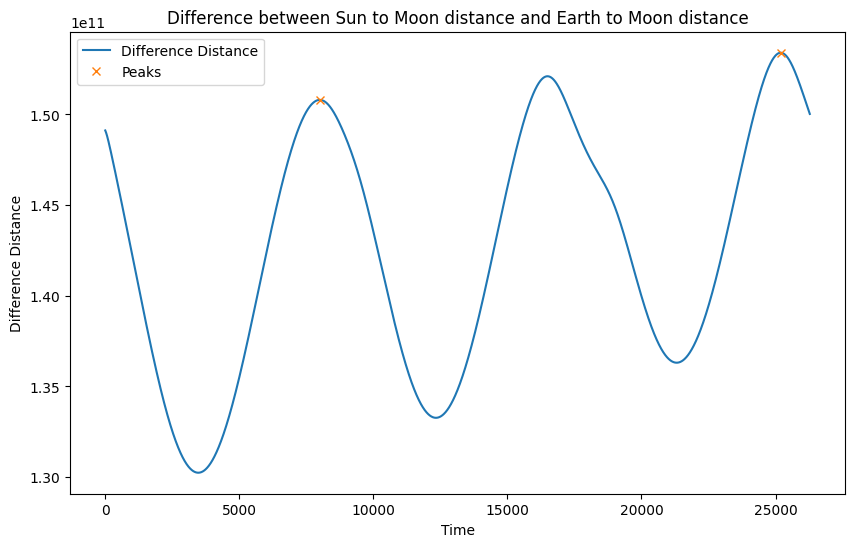

In [10]:
# Plot the difference between the Sun to Moon distance and the Earth to Moon distance
plt.figure(figsize=(10, 6))
plt.plot(difference_distance, label='Difference Distance')
plt.plot(peaks, difference_distance[peaks], "x", label='Peaks')
plt.xlabel('Time')
plt.ylabel('Difference Distance')
plt.title('Difference between Sun to Moon distance and Earth to Moon distance')
plt.legend()
plt.show()

# Simulations for other masses

In [11]:
# create list of names of files to run
csv_files = os.listdir()

In [12]:
for file in csv_files[:]:
    if file.startswith('normal'):
        csv_files.remove(file)
    elif file.endswith('csv'):
        continue
    else:
        csv_files.remove(file)

In [13]:
csv_files

['100_times_moon_mass.csv',
 '10_times_moon_mass.csv',
 '130_percent_sun_mass.csv',
 '2_times_moon_mass.csv',
 '50_times_moon_mass.csv',
 '70_percent_sun_mass.csv']

Filename is: 100_times_moon_mass.csv
Eccentricity is 0.0132.


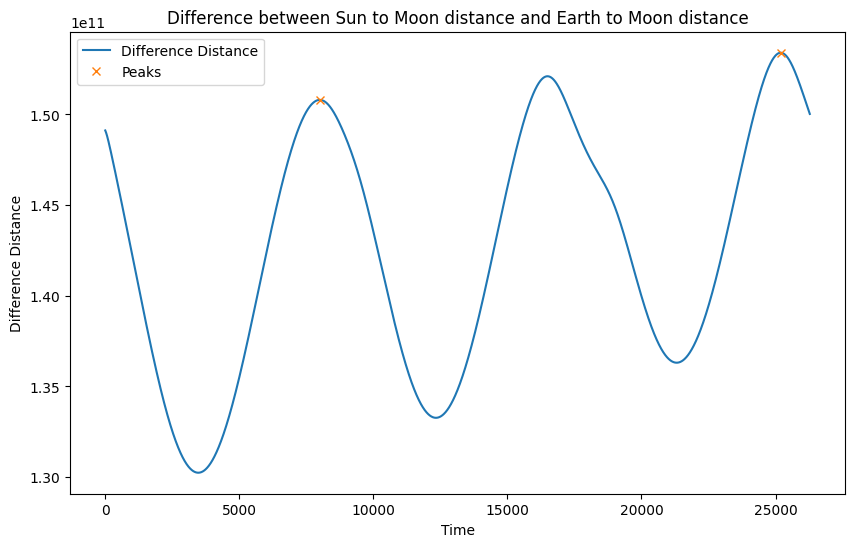

Filename is: 10_times_moon_mass.csv
Eccentricity is 0.0132.


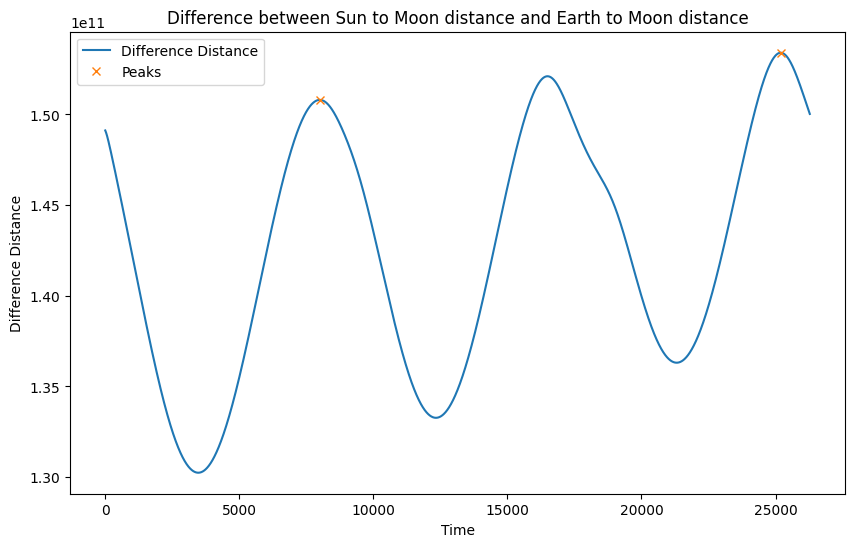

Filename is: 130_percent_sun_mass.csv
Eccentricity is 0.2617.


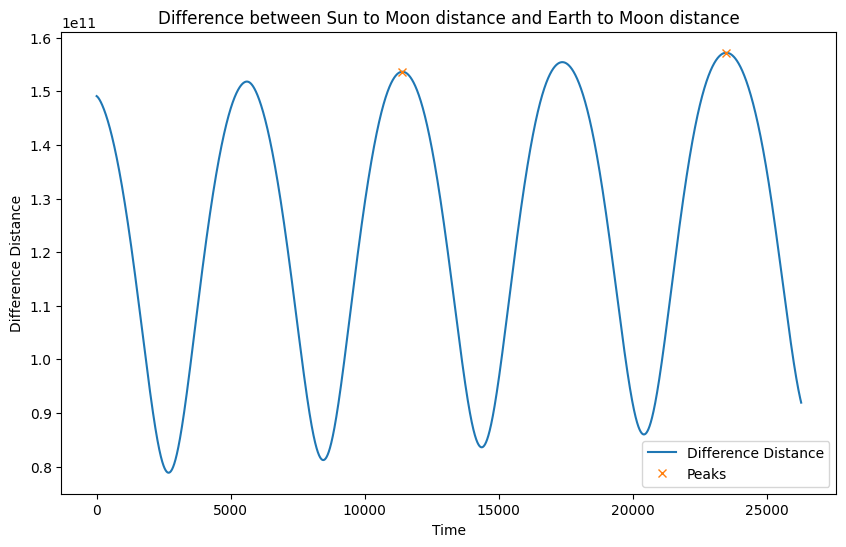

Filename is: 2_times_moon_mass.csv
Eccentricity is 0.0132.


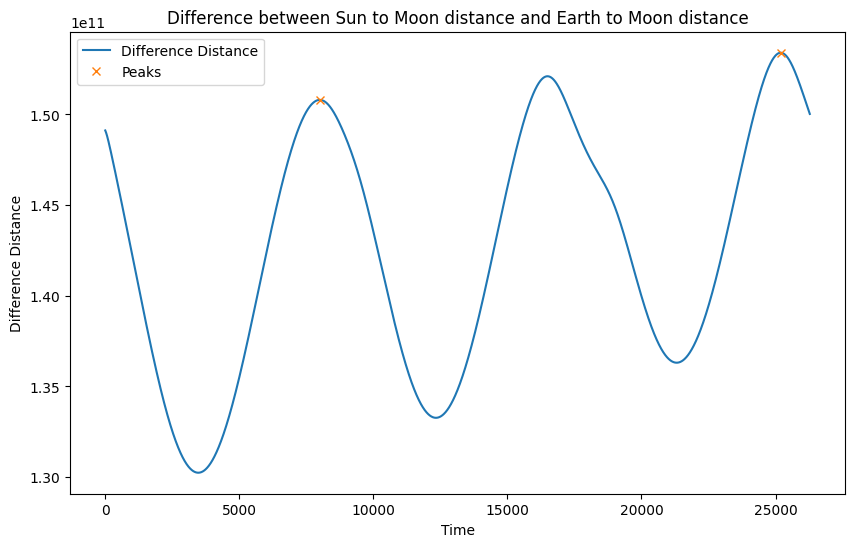

Filename is: 50_times_moon_mass.csv
Eccentricity is 0.0132.


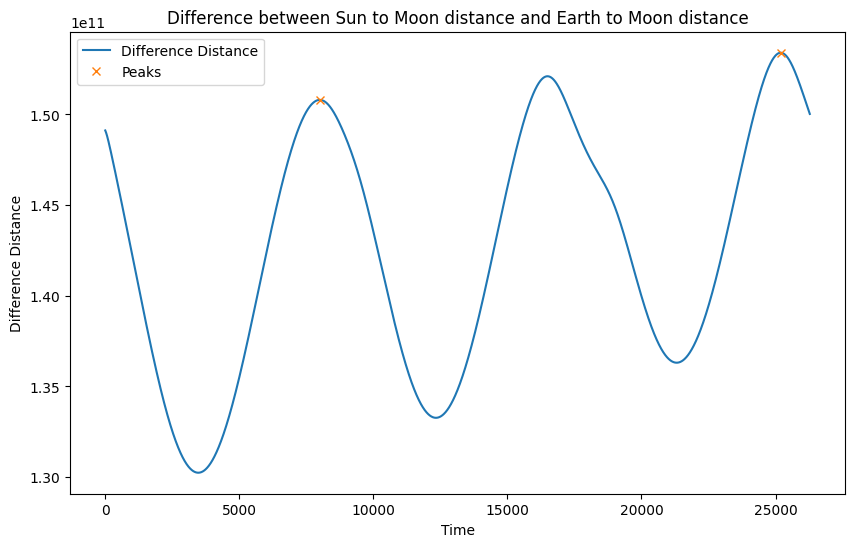

Filename is: 70_percent_sun_mass.csv
Eccentricity is 0.4295.


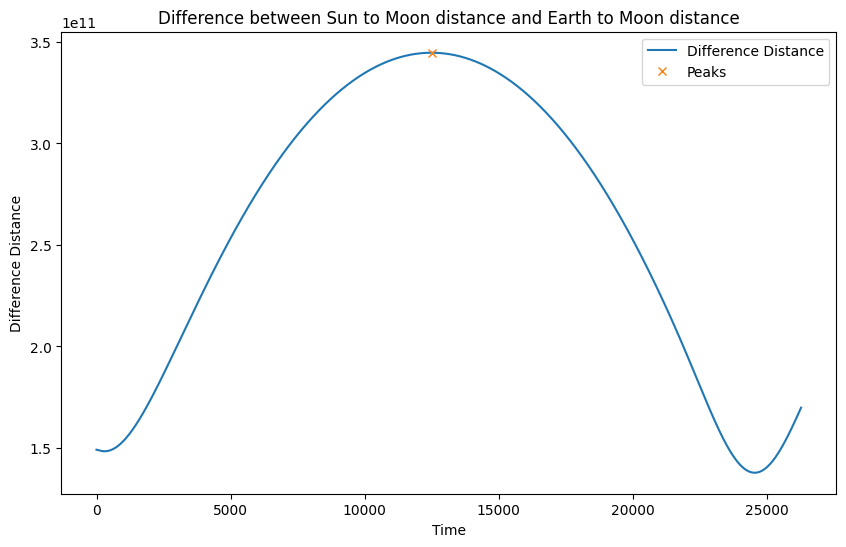

In [14]:
for file in csv_files:
    eccentricity, peaks, difference_distance = calculate_eccentricity_periodicity(file)
    print("Filename is:",file)
    print("Eccentricity is",eccentricity+".")
    plt.figure(figsize=(10, 6))
    plt.plot(difference_distance, label='Difference Distance')
    plt.plot(peaks, difference_distance[peaks], "x", label='Peaks')
    plt.xlabel('Time')
    plt.ylabel('Difference Distance')
    plt.title('Difference between Sun to Moon distance and Earth to Moon distance')
    plt.legend()
    plt.show()

In [15]:
csv_files.append('normal.csv')

In [25]:
# generate gif files
for file in csv_files:
    os.system(f'python animate_orbits.py --filename {file} --output {file[:-4]}') 
# please note, I have modified animate_orbits so that the name of the gif file can be pre-entered, therefore it is taking the output argument for that

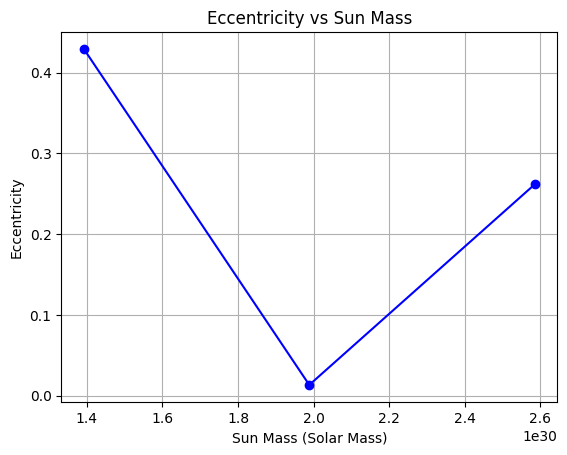

In [2]:
import matplotlib.pyplot as plt
m_sun = 1.98847e30
sun_mass_values = [0.7 * m_sun, m_sun, 1.3 * m_sun]  # replace with your actual data
eccentricity_values = [0.4295, 0.0132, 0.2617]  # replace with your actual data

# Plotting the data
plt.plot(sun_mass_values, eccentricity_values, marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Sun Mass (Solar Mass)')
plt.ylabel('Eccentricity')
plt.title('Eccentricity vs Sun Mass')

# Display the plot
plt.grid(True)
plt.show()
